# Autoregressive Moving Average (ARMA) Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/04-ARMA-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>

## The Purely Random Process

A purely random process (also known as a white noise process) is a stochastic process where the value at time $t$, denoted as $e_t$ is uncorrelated with its past values and has a constant mean and variance.

$$
E(e_t) = 0, \\
Var(e_t) = E(e_t^2) = \sigma^2 \\ 
Cov(e_t, e_{t-k}) = E(e_t e_{t-k}) = 0 \text{ for } k \neq 0
$$

It is a stationary process since its statistical properties (level, fluctuations and autocorrelation) do not change over time.

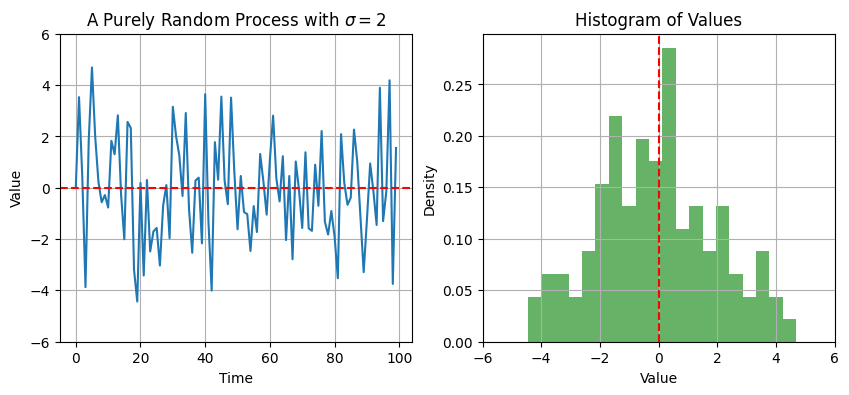

In [1]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sigma = 2
e = np.random.normal(loc = 0, scale=sigma, size=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(e)
ax[0].set_title(rf"A Purely Random Process with $\sigma={sigma}$")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_ylim(-6, 6)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].grid()

ax[1].hist(e, bins=20, density=True, alpha=0.6, color='g')
ax[1].set_title("Histogram of Values")
ax[1].set_xlim(-6, 6)
ax[1].axvline(0, color='red', linestyle='--')
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Density")
ax[1].grid()

## Auto-correlation and Partial Auto-correlation Functions

The (empirical) auto-correlation function (ACF) measures the correlation between observations of a time series separated by various time lags.

The auto-correlation at lag $k$ is defined as:

$$
\hat{\rho}(k) = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$$

where the numerator is the empirical covariance at lag $k$ and the denominator is the variance of the series.

The partial auto-correlation function (PACF) measures the correlation between observations of a time series separated by lag $k$, after removing the effects of all shorter lags (1 to $k-1$). We will come back to this later when we discuss AR processes.

Text(0.5, 1.0, 'Partial Auto-correlation of White Noise')

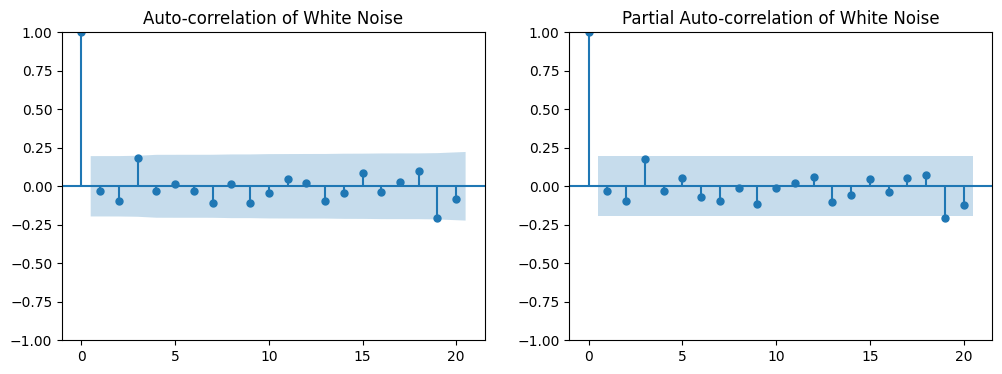

In [2]:
# Auto-correlation

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(e, lags=20, ax=ax[0])
ax[0].set_title("Auto-correlation of White Noise")

# Partial Auto-correlation
plot_pacf(e, lags=20, ax=ax[1])
ax[1].set_title("Partial Auto-correlation of White Noise")

## Autoregressive Processes (AR)

An autoregressive process of order $p$, denoted as AR($p$), is a stochastic process where the current value of the series is expressed as a linear combination of its previous $p$ values and a random error term.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where:
- $x_t$ is the value of the series at time $t$,
- $\phi_1, \phi_2, ..., \phi_p$ are the parameters of the model,
- $e_t$ is a white noise error term with mean zero and constant variance $\sigma^2$.

## The AR(1) Process

The simplest autoregressive process is the AR(1) process, where the current value depends only on its immediate past value.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + e_t
$$

In the discussion about difference equations, we saw that the AR(1) is stable if $|\phi| < 1$. What about the statistical properties of the AR(1) process?

### Expected Value (Mean)

$$
\begin{align*}
E(x_t) & = \frac{\phi_0}{1 - \phi_1}
\end{align*}
$$

### Variance, Covariance and Auto-correlation Function (ACF)

$$
\begin{align*}
\gamma(0) & = Var(x_t) = \frac{\sigma^2}{1 - \phi_1^2}
\end{align*}
$$

The covariances can be derived similarly by assuming that the constant is zero and taking the expected value of the product $x_t$ and $x_{t-k}$:

$$
\begin{align*}
\gamma(1) = Cov(x_t, x_{t-1}) & = \phi_1 \gamma(0)
\end{align*}
$$

For $k = 2$, we have:

$$
\begin{align*}
\gamma(2) = Cov(x_t, x_{t-2}) & = \phi_1^2 \gamma(0)\\
& = E[(\phi_1 x_{t-1} + e_t)x_{t-2}] \\
& = \phi_1 E(x_{t-1} x_{t-2}) + E(e_t x_{t-2}) \\
& = \phi_1 \gamma(1) + 0 \\
 \\
\end{align*}
$$

Continuing this process, we find that for any lag $k$:

$$
\gamma(k) = \phi_1^k \gamma(0)
$$

The autocorrelation function (ACF) is obtained by normalizing the covariances by the variance:

$$
\rho(k) = \frac{\gamma(k)}{\gamma(0)} = \phi_1^k
$$


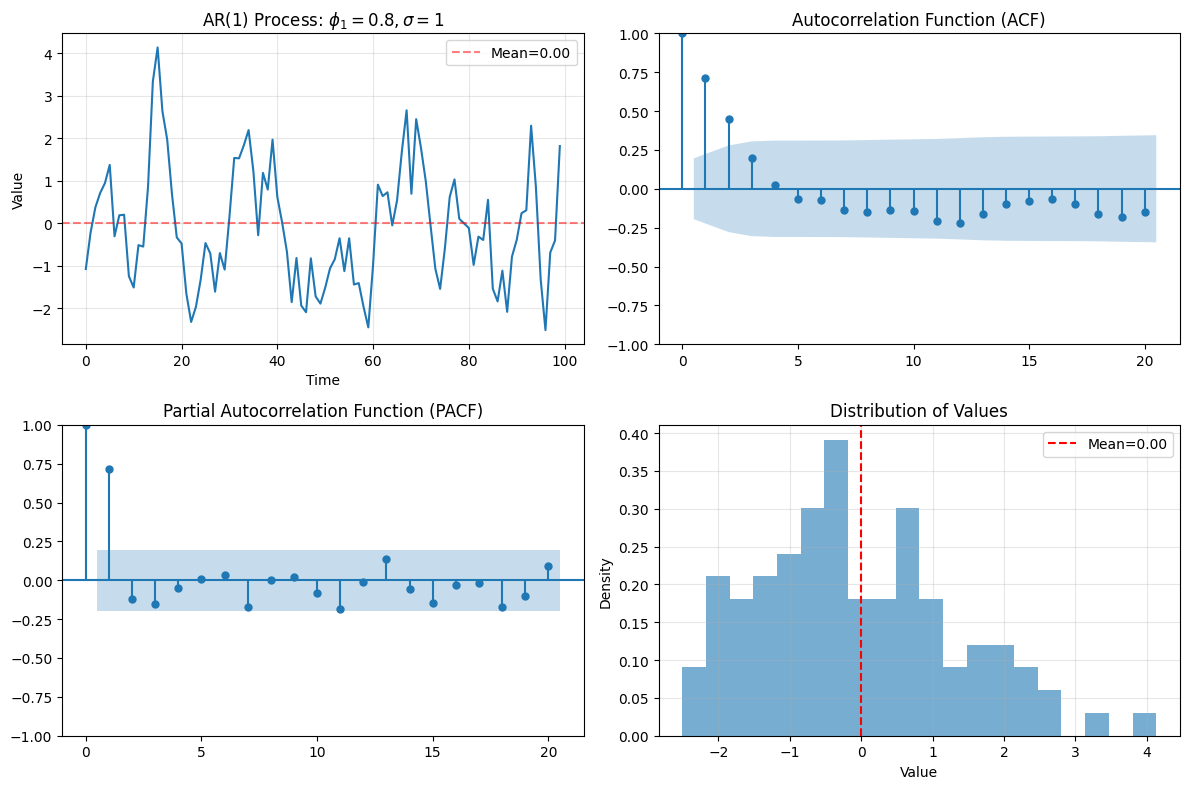

In [3]:
# Simulate AR(1) process with phi_0 = 0, phi_1 = 0.8, sigma = 1


# AR(1) parameters
phi_1 = 0.8  # AR coefficient
sigma = 1  # standard deviation of noise
n = 100

x = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=sigma)

# Plot the AR(1) process
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Time series plot

ax[0, 0].plot(x)
ax[0, 0].set_title(fr"AR(1) Process: $\phi_1 ={phi_1}, \sigma ={sigma}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot
plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")

# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## AR (2) Process

The AR(2) process is defined as:

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + e_t
$$

where the error term $e_t$ is white noise with mean zero and constant variance $\sigma^2$. For simplicity in the following example, we will set $\phi_0 = 0$ which implies that the mean of the process is zero (this is convenient for calculating the variance and covariances).

### Stationarity Conditions

A stochastic process is stationary if its statistical properties (mean, variance, autocovariance) do not change over time. We have already discussed the stability of second-order difference equations, which is a necessary condition for stationarity. We can derive the characteristic equation without referring to the vector autoregressive representation by looking at the lag-polynomial associated with the AR(2) process:

The lag-operator (back-shift operator) $B$ is defined as:

$$
\begin{align*}
B x_t &= x_{t-1} \\
B^2 x_t &= B(B x_t) = B x_{t-1} = x_{t-2}
\end{align*}
$$

We can rewrite the AR(2) process using the lag-operator:

$$
x_t = \phi_1 B x_t + \phi_2 B^2 x_t + e_t
$$

Rearranging terms, we get:

$$
(1 - \phi_1 B - \phi_2 B^2) x_t = e_t
$$

The characteristic equation is obtained by setting the lag-polynomial equal to zero and substituting $B$ with $1/\lambda$:

$$
1 - \phi_1 \lambda^{-1} - \phi_2 \lambda^{-2} = 0
$$

Now we can multiply through by $\lambda^2$ to get the standard form of the characteristic equation:

$$
\lambda^2 - \phi_1 \lambda - \phi_2 = 0
$$

The roots of this equation can be found using the quadratic formula:

$$
\lambda^{*}_{1,2} = \frac{\phi_1 \pm \sqrt{\phi_1^2 + 4 \phi_2}}{2}
$$

Exercise: are the processes with the following parameters stationary?

1. $\phi_1 = 0.5$, $\phi_2 = 0.2$
2. $\phi_1 = 1.2$, $\phi_2 = -0.5$
3. $\phi_1 = -0.4$, $\phi_2 = 0.3$

Use `np.roots` to compute the roots of the characteristic equation for different values of $\phi_1$ and $\phi_2$ and `np.abs` to check their magnitudes.


## Complex Roots

When the roots of the characteristic equation are complex, the autocorrelation function (ACF) exhibits oscillatory behavior. To see why this happens, let's consider the model:

$$
x_t = 0.8 x_{t-1} - 0.64 x_{t-2} + e_t
$$

Its lag-polynomial form is:

$$
(1 - 0.8 B + 0.64 B^2) x_t = e_t
$$

and hence the characteristic equation is:

$$
\lambda^2 - 0.8 \lambda + 0.64 = 0
$$

We can find the roots by calling `np.roots([1, -0.8, 0.64])`, which gives us the complex roots:

In [4]:
np.roots([1, -0.8, 0.64])

array([0.4+0.69282032j, 0.4-0.69282032j])

The two complex roots are:

$$
\begin{align*}
\lambda^{*}_{1} & = 0.4 + 0.48i\\
\lambda^{*}_{2} & = 0.4 - 0.48i
\end{align*}
$$

It is useful to visualize these roots in the complex plane to understand their implications for the behavior of the AR(2) process.

In [6]:
# Plotly: complex roots of AR(2) characteristic equation with unit circle

import numpy as np
import plotly.graph_objects as go
import pandas as pd

# AR(2): x_t = phi1 x_{t-1} + phi2 x_{t-2} + e_t
phi1 = 0.8
phi2 = -0.64  # Note the sign so that coeffs are [1, -phi1, -phi2] = [1, -0.8, 0.64]

coeffs = [1, -phi1, -phi2]
roots = np.roots(coeffs)

df_roots = pd.DataFrame({
    "root": [f"λ₁", f"λ₂"],
    "real": roots.real,
    "imag": roots.imag,
    "modulus": np.abs(roots)
})
print(df_roots)

# Unit circle
theta = np.linspace(0, 2*np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

fig = go.Figure()

# Unit circle
fig.add_trace(go.Scatter(x=circle_x, y=circle_y,
                         mode="lines", name="Unit circle",
                         line=dict(color="lightgray")))

# Roots
fig.add_trace(go.Scatter(x=roots.real, y=roots.imag,
                         mode="markers+text",
                         name="Roots",
                         text=[f"{r.real:.1f} + {r.imag:.1f}i" for r in roots],
                         textposition="top center",
                         marker=dict(size=12, color="red")))

# Axes
fig.add_shape(type="line", x0=-1.2, x1=1.2, y0=0, y1=0,
              line=dict(color="black", width=1))
fig.add_shape(type="line", x0=0, x1=0, y0=-1.2, y1=1.2,
              line=dict(color="black", width=1))

fig.update_layout(title="Complex Roots of AR(2) Characteristic Equation",
                  xaxis_title="Real Part",
                  yaxis_title="Imaginary Part",
                  xaxis=dict(scaleanchor="y", range=[-1.2, 1.2]),
                  yaxis=dict(range=[-1.2, 1.2]),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig.show()

  root  real     imag  modulus
0   λ₁   0.4  0.69282      0.8
1   λ₂   0.4 -0.69282      0.8


What happens with the complex roots when we start taking powers of them? Take the first root and compute its square.

$$
\begin{align*}
\lambda^{*2}_{1} & = (0.4 + 0.48i)^2 = 0.16 + 2 \cdot 0.4 \cdot 0.48i + (0.48i)^2 \\
& = 0.16 + 0.384i - 0.2304 \\
& = -0.0704 + 0.384i
\end{align*}
$$


In [8]:
# Plot the squared roots on the complex plane

import plotly.graph_objects as go
import numpy as np

# Squared roots
squared_roots = [r**2 for r in roots]
fig = go.Figure()
# Unit circle
theta = np.linspace(0, 2*np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
fig.add_trace(go.Scatter(x=circle_x, y=circle_y,
                         mode="lines", name="Unit circle",
                         line=dict(color="lightgray")))
# Squared Roots
fig.add_trace(go.Scatter(x=[r.real for r in squared_roots],
                         y=[r.imag for r in squared_roots],
                         mode="markers+text",
                         name="Squared Roots",
                         text=[f"{r.real:.2f} + {r.imag:.2f}i" for r in squared_roots],
                         textposition="top center",
                         marker=dict(size=12, color="blue")))
# Axes
fig.add_shape(type="line", x0=-1.2, x1=1.2, y0=0, y1=0,
              line=dict(color="black", width=1))
fig.add_shape(type="line", x0=0, x1=0, y0=-1.2, y1=1.2,
              line=dict(color="black", width=1))
fig.update_layout(title="Squared Roots of AR(2) Characteristic Equation",
                  xaxis_title="Real Part",
                  yaxis_title="Imaginary Part",
                  xaxis=dict(scaleanchor="y", range=[-1.2, 1.2]),
                  yaxis=dict(range=[-1.2, 1.2]),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Add the original roots for reference

fig.add_trace(go.Scatter(x=roots.real, y=roots.imag,
                         mode="markers+text",
                            name="Original Roots",
                            text=[f"{r.real:.2f} + {r.imag:.2f}i" for r in roots],
                            textposition="bottom center",
                            marker=dict(size=8, color="red", symbol="x")))

fig.show()

In [33]:
root_exp = np.power(0.4 + 0.7j, 1)
print(root_exp)

np.abs(root_exp)

(0.4+0.7j)


np.float64(0.8062257748298549)

In [34]:
# Create an animation showing the first 20 powers of both roots on the complex plane

import plotly.graph_objects as go
import numpy as np

# Prepare data for animation
max_power = 20
frames = []

# Use more frames for smoother animation - start from 1 instead of 0
powers_range = np.linspace(1, max_power, 100)

# Unit circle for reference
theta = np.linspace(0, 2*np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Create frames for each power
for power in powers_range:
    # Calculate root powers
    root1_power = roots[0]**power
    root2_power = roots[1]**power
    
    frame_data = [
        # Unit circle (stays constant)
        go.Scatter(
            x=circle_x, 
            y=circle_y,
            mode="lines", 
            name="Unit circle",
            line=dict(color="lightgray"),
            showlegend=True
        ),
        # Root 1
        go.Scatter(
            x=[root1_power.real], 
            y=[root1_power.imag],
            mode="markers+text",
            name="λ₁",
            text=[f"{root1_power.real:.2f} + {root1_power.imag:.2f}i"],
            textposition="top center",
            marker=dict(size=12, color="red"),
            showlegend=True
        ),
        # Root 2
        go.Scatter(
            x=[root2_power.real], 
            y=[root2_power.imag],
            mode="markers+text",
            name="λ₂",
            text=[f"{root2_power.real:.2f} + {root2_power.imag:.2f}i"],
            textposition="bottom center",
            marker=dict(size=12, color="blue"),
            showlegend=True
        )
    ]
    
    frames.append(go.Frame(
        data=frame_data,
        name=f"Power {power:.2f}",
        layout=go.Layout(
            title_text=f"Powers of Roots: λ^{power:.2f}"
        )
    ))

# Create initial figure with power 1 (the original roots)
fig = go.Figure(
    data=[
        go.Scatter(
            x=circle_x, 
            y=circle_y,
            mode="lines", 
            name="Unit circle",
            line=dict(color="lightgray")
        ),
        go.Scatter(
            x=[roots[0].real], 
            y=[roots[0].imag],
            mode="markers+text",
            name="λ₁",
            text=[f"{roots[0].real:.2f} + {roots[0].imag:.2f}i"],
            textposition="top center",
            marker=dict(size=12, color="red")
        ),
        go.Scatter(
            x=[roots[1].real], 
            y=[roots[1].imag],
            mode="markers+text",
            name="λ₂",
            text=[f"{roots[1].real:.2f} + {roots[1].imag:.2f}i"],
            textposition="bottom center",
            marker=dict(size=12, color="blue")
        )
    ],
    frames=frames
)

# Add play and pause buttons
fig.update_layout(
    title="Powers of Complex Roots of AR(2) Characteristic Equation",
    xaxis_title="Real Part",
    yaxis_title="Imaginary Part",
    xaxis=dict(scaleanchor="y", range=[-1.2, 1.2]),
    yaxis=dict(range=[-1.2, 1.2]),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(
                    label="▶ Play",
                    method="animate",
                    args=[
                        None,
                        {
                            "frame": {"duration": 100, "redraw": False},
                            "fromcurrent": True,
                            "transition": {"duration": 50, "easing": "linear"}
                        }
                    ]
                ),
                dict(
                    label="⏸ Pause",
                    method="animate",
                    args=[
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }
                    ]
                )
            ],
            x=0.1,
            y=0,
            xanchor="left",
            yanchor="top"
        )
    ],
    sliders=[
        dict(
            active=0,
            steps=[
                dict(
                    args=[
                        [f.name],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }
                    ],
                    label=f"{float(f.name.split()[-1]):.1f}",
                    method="animate"
                )
                for f in frames[::5]  # Show every 5th frame label to avoid clutter
            ],
            x=0.1,
            y=0,
            currentvalue=dict(
                font=dict(size=12),
                prefix="Power: ",
                visible=True,
                xanchor="left"
            ),
            len=0.9,
            xanchor="left",
            yanchor="top"
        )
    ]
)

# Add axis lines
fig.add_shape(type="line", x0=-1.2, x1=1.2, y0=0, y1=0,
              line=dict(color="black", width=1))
fig.add_shape(type="line", x0=0, x1=0, y0=-1.2, y1=1.2,
              line=dict(color="black", width=1))

fig.show()

### The Yule-Walker Equations

It is easiest to derive the Yule-Walker equations for an AR(2) process. Assuming that the mean of the process is zero (i.e., $\phi_0 = 0$), we can derive the variance and covariances by multiplying both sides of the AR(2) equation by $x_t$, $x_{t-1}$, and $x_{t-2}$ and taking expectations.

$$
\begin{align*}
\gamma(0) & = \phi_1 \gamma(1) + \phi_2 \gamma(2) + \sigma^2 \\
\gamma(1) & = \phi_1 \gamma(0) + \phi_2 \gamma(1) \\
\gamma(2) & = \phi_1 \gamma(1) + \phi_2 \gamma(0)
\end{align*}
$$

## The Partial Autocorrelation Function (PACF)

The partial autocorrelation function (PACF) measures the correlation between a time series and its lagged values, after removing the effects of intervening lags. In other words, it quantifies the direct relationship between $x_t$ and $x_{t-k}$, controlling for the influence of all intermediate lags ($x_{t-1}, x_{t-2}, ..., x_{t-(k-1)}$).

To see this, consider a regression model for 

$$
\text{income}_i = \beta_0 + \beta_1 \text{age}_{i} + \beta_2 \text{experience}_{i} + e_i 
$$

In [36]:
import pandas as pd

dt = pd.read_csv("https://raw.githubusercontent.com/febse/data/refs/heads/main/ts/multiple_linear_regression_dataset_age_income_experience.csv")
dt.head()

,age,experience,income
0,25,1,30450
1,30,3,35670
2,47,2,31580
3,32,5,40130
4,43,10,47830


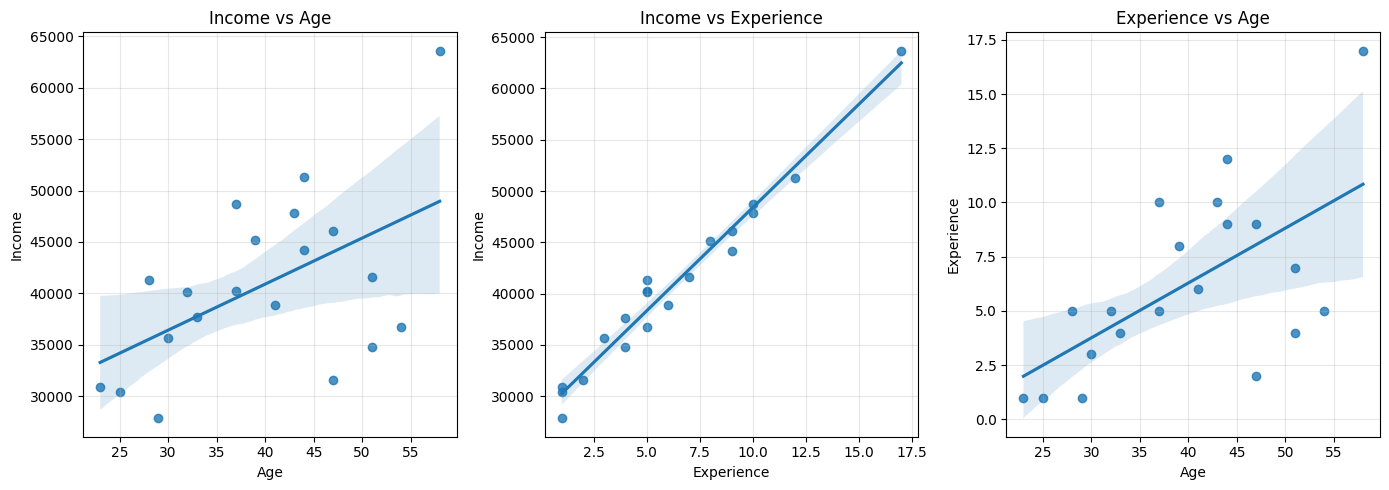

In [37]:
# Plot income vs age and experience with regression lines using seaborn
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Income vs Age
sns.regplot(x='age', y='income', data=dt, ax=ax[0])
ax[0].set_title("Income vs Age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Income")
ax[0].grid(alpha=0.3)

# Income vs Experience
sns.regplot(x='experience', y='income', data=dt, ax=ax[1])
ax[1].set_title("Income vs Experience")
ax[1].set_xlabel("Experience")
ax[1].set_ylabel("Income")
ax[1].grid(alpha=0.3)

# Income vs Hours Worked
sns.regplot(x='age', y='experience', data=dt, ax=ax[2])
ax[2].set_title("Experience vs Age")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Experience")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
from statsmodels.regression.linear_model import OLS

model = OLS(dt['income'], dt[['age', 'experience']]).fit()
model.params


age            746.145230
experience    1532.010768
dtype: float64

In [39]:
model_income_age = OLS(dt["income"], dt["age"]).fit()
model_income_age.params


age    994.184631
dtype: float64

To calculate the partial correlation between income and experience, controlling for age, we
regress income on age and compute the residuals. We then regress experience on age and compute the residuals. Finally, we calculate the correlation between the two sets of residuals. This correlation is the partial correlation between income and experience, controlling for age.

In [40]:
model_experience_age = OLS(dt["experience"], dt["age"]).fit()
model_experience_age.params

age    0.161904
dtype: float64

In [41]:
np.corrcoef(model_income_age.resid, model_experience_age.resid)

array([[1.        , 0.58728427],
       [0.58728427, 1.        ]])

In [42]:
np.corrcoef(dt["income"], dt["experience"])

array([[1.        , 0.98422664],
       [0.98422664, 1.        ]])

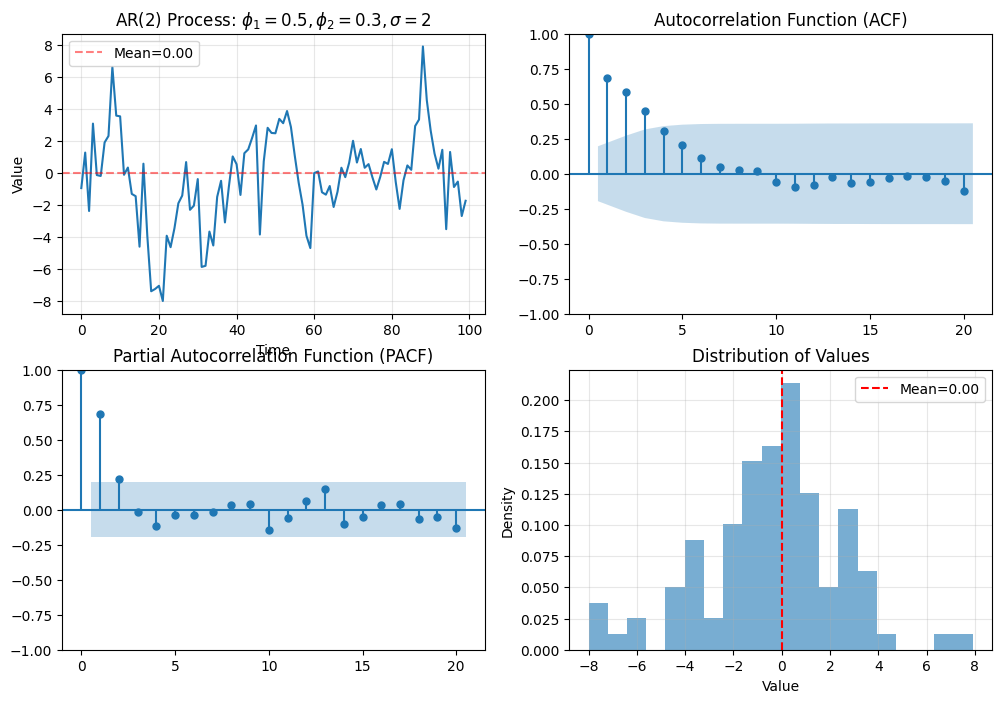

In [44]:
## Simulate an AR(2) process with phi_0 = 0, phi_1 = 0.5, phi_2 = 0.3, sigma = 2

phi_1 = 0.5
phi_2 = 0.3
sigma = 2
n = 100

x_ar2 = arma_generate_sample(ar=[1, -phi_1, -phi_2], ma=[1], nsample=n, scale=sigma)

# Plot the sample

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
# Time series plot
ax[0, 0].plot(x_ar2)
ax[0, 0].set_title(fr"AR(2) Process: $\phi_1 ={phi_1}, \phi_2 ={phi_2}, \sigma ={sigma}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot
plot_acf(x_ar2, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")
# PACF plot
plot_pacf(x_ar2, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")
# Histogram
ax[1, 1].hist(x_ar2, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)

## Moving Average (MA) Processes

A simple moving average process of order $q$, denoted as MA(q), is defined as:

$$
x_t = e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q}
$$

where:
- $x_t$ is the value of the time series at time $t$.
- $e_t$ is a white noise error term at time $t$.
- $\theta_1, \theta_2, ..., \theta_q$ are the parameters of the model.

The moving average process of order 1 only includes the immediate past error term:

$$
x_t = e_t + \theta_1 e_{t-1}
$$

The expected value of this process is zero, because it is a linear combination of white noise terms, each of which has an expected value of zero.

$$
E(x_t) = E(e_t) + \theta_1 E(e_{t-1}) = 0 + \theta_1 \cdot 0 = 0
$$

We can calculate its variance by using the result that its mean is zero (see above). 

$$
\begin{align*}
Var(x_t) & = E(x_t^2) \\
         & = E\left((e_t + \theta_1 e_{t-1})^2\right) \\
         & = E\left(e_t^2 + 2\theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1}^2\right) \\
         & = E(e_t^2) + 2\theta_1 E(e_t e_{t-1}) + \theta_1^2 E(e_{t-1}^2) \\        
         & = \sigma^2 + 2\theta_1 \cdot 0 + \theta_1^2 \sigma^2 \\
         & = (1 + \theta_1^2) \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k = 1$ is given by:

$$
\begin{align*}
\gamma(1) & = Cov(x_t, x_{t-1}) \\
          & = E\left[(x_t - E(x_t))(x_{t-1} - E(x_{t-1}))\right] \\
          & = E(x_t x_{t-1}) \\
          & = E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-1} + \theta_1 e_t e_{t-2} + \theta_1 e_{t-1}^2 + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \sigma^2 + \theta_1^2 \cdot 0 \\
          & = \theta_1 \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k > 1$ is zero, see for example lag $k = 2$ below:

$$
\begin{align*}
\gamma(2) & = E(x_t x_{t-2}) \\
          & =  E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-2} + \theta_1 e_{t-1} e_{t-2} + \theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \cdot 0 + \theta_1^2 \cdot 0 \\
          & = 0
\end{align*}          
$$


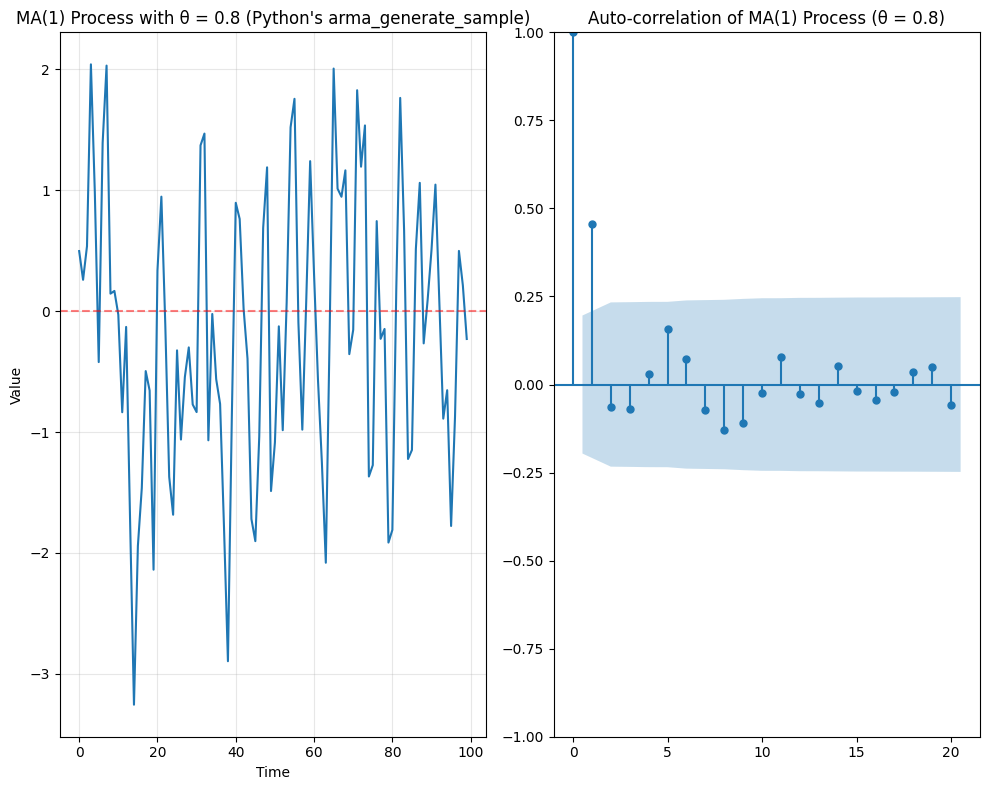

Mean of MA(1) process: -0.1850
Variance of MA(1) process: 1.3120
Theoretical variance: 1.6400
Theoretical ACF at lag 1: 0.4878


In [32]:
# Simulate MA(1) process with theta = 0.8, sigma = 1

from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(42)

# MA(1) parameters
theta = 0.8
n = 100

# Generate MA(1) sample
x = arma_generate_sample(ar=[1], ma=[1, theta], nsample=n, scale=1)

# Plot the MA(1) process
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(x)
ax[0].set_title(f"MA(1) Process with θ = {theta} (Python's arma_generate_sample)")
ax[0].axhline(0, color='red', linestyle='--', alpha=0.5)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].grid(alpha=0.3)

# Plot ACF
plot_acf(x, lags=20, ax=ax[1])
ax[1].set_title(f"Auto-correlation of MA(1) Process (θ = {theta})")

plt.tight_layout()
plt.show()

print(f"Mean of MA(1) process: {np.mean(x):.4f}")
print(f"Variance of MA(1) process: {np.var(x):.4f}")
print(f"Theoretical variance: {1 + theta**2:.4f}")
print(f"Theoretical ACF at lag 1: {theta / (1 + theta**2):.4f}")